# The Risk of Informal Benchmarking

In [1]:
from sensemakr import sensemakr
from sensemakr import ovb_bounds
from sensemakr.ovb_plots import *
from sensemakr.sensitivity_stats import *
from sensemakr.bias_functions import *
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

In [2]:
def resid_maker(n,df):
    N=np.random.normal(0,1,n)
    form='N~' +'+'.join(df.columns)
    df['N']=N
    model=smf.ols(formula=form,data=df).fit()
    e = model.resid
    e = (e-np.mean(e))/np.std(e)
    return(e)

In [3]:
# simulates data
n=100
X=np.random.normal(0,1,n)
X=(X-np.mean(X))/np.std(X)
Z=resid_maker(n,pd.DataFrame({'x':X}))
D=X+Z+resid_maker(n,pd.DataFrame({'x':X,'z':Z}))
Y=X+Z+resid_maker(n,pd.DataFrame({'x':X,'z':Z,'d':D}))

In [4]:
df=pd.DataFrame({'Y':Y,'X':X,'Z':Z,'D':D})
model_ydx=smf.ols(formula='Y~D+X',data=df).fit()

In [5]:
model_ydx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     48.50
Date:                Wed, 08 Dec 2021   Prob (F-statistic):           2.51e-15
Time:                        14:57:48   Log-Likelihood:                -162.17
No. Observations:                 100   AIC:                             330.3
Df Residuals:                      97   BIC:                             338.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.388e-17      0.124   1.12e-16      1.000      -0.247       0.247
D              0.5000      0.088      5.686      0.000       0.325       0.675
X              0.5000      0.152      3.283      0.001       0.198       0.802
==============================================================================
Omnibus:                        1.062   Durbin-Watson:                   2.488
Prob(Omnibus):                  0.588   Jarque-Bera (JB):                1.097
Skew:                           0.146   Prob(JB):                        0.578
Kurtosis:                       2.578   Cond. No.                         2.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
# fits treatment regression
model_dx=smf.ols(formula='D~X',data=df).fit()

In [7]:
# computes observed partial R2 of X
r2yx_d=partial_r2(model_ydx,covariates='X')
r2dx=partial_r2(model_dx,covariates='X')

In [8]:
informal_adjusted_estimate=adjusted_estimate(model=model_ydx,treatment="D",r2dz_x=r2dx,r2yz_dx=r2yx_d)

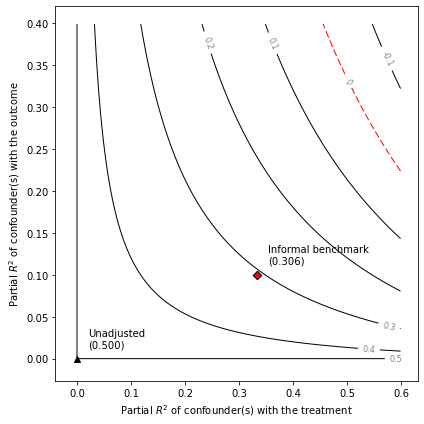

In [9]:
# draws sensitivity contours
ovb_contour_plot(model=model_ydx,treatment="D",lim=0.6)

# adds informal benchmark
add_bound_to_contour(r2dz_x=r2dx,r2yz_dx=r2yx_d,bound_value=informal_adjusted_estimate,
                     bound_label='Informal benchmark')

In [10]:
# compute formal bounds
formal_bound=ovb_bounds.ovb_bounds(model=model_ydx,treatment='D',benchmark_covariates="X",kd=1,ky=1)

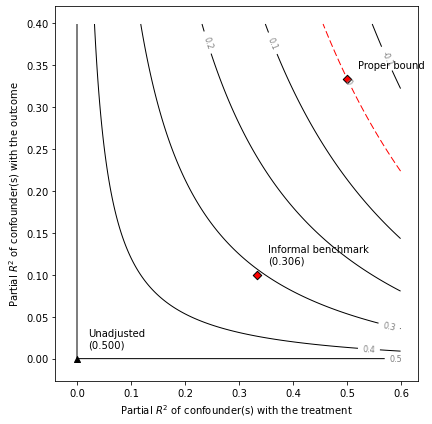

In [11]:
# contour plot
ovb_contour_plot(model=model_ydx,treatment="D",lim=0.6)
add_bound_to_contour(r2dz_x=r2dx,r2yz_dx=r2yx_d,bound_value=informal_adjusted_estimate,
                     bound_label='Informal benchmark')
add_bound_to_contour(bounds=formal_bound,
                     bound_label='Proper bound')